In [2]:
# Library Imports
import sympy as sp
sp.init_printing()
import numpy as np
from IPython.display import display, Latex

## Symbolic variables definition

In [3]:
# x coordinates
x = sp.Symbol("x")
x0 = sp.Symbol("x_{0}")
dx = sp.Symbol("Δx")
nx = sp.Symbol("n_{x}", integer=True)
i = sp.Idx("i",nx)
X = sp.IndexedBase('X')
x, x0, dx, nx, i, X

(x, x_{0}, Δx, n_{x}, i, X)

In [4]:
# y coordinates
y = sp.Symbol("y")
y0 = sp.Symbol("y_{0}")
dy = sp.Symbol("Δy")
ny = sp.Symbol("n_{y}", integer=True)
j = sp.Idx("j",ny)
Y = sp.IndexedBase('Y')
y, y0, dy, ny, i, Y

(y, y_{0}, Δy, n_{y}, i, Y)

# Problem Setup

The first step in obtaining a numerical solution is to convert the (continuous) domain of interest into a discretized domain.
In 2D Finite Difference schemes, each dicrete point on the grid, or "node", is uniquely identified by a set of indices (i,j). The neighbouring nodes are defined by incrementing or decrementing one of the indices by one.

VI NOTE HERE: Show a picture of the 2D domain here and show the indices change with that beautiful latex image.

The continuous PDE equations have been discretized into a system of linear algebraic variables, where each node has one unknown variable and is the subject of one algebraic equation, representing the relstionship between the node and its neighbours. Therefore, any dicretized domain can be expressed as a system of linear equations where the number of equations and unknowns must be equal, in a square matrix. In our problem, the domain of interest has temperature defined as $u = u(x,y)$ and is discretized into $U_{\left(i,j\right)}$ at each node, where x is the distance from the origin in the horizontal direction and y is the distance from the origin in the vertical direction.

At boundary conditions, where nodes may not have the usual amount of neighbouring nodes or may be subject to physical constraints, special equations need to be derived. These equations are still linear in form and can be used to replace a row in the matrix. In addition to the conditions placed on boundary nodes, we may have null nodes that are not part of the domain but are values that may be expressed using the indices. Such null nodes will have the value 0 and will not be incorporated in the calculation of other nodes. In the T-shaped domain under study, we have two regions filled with such null nodes.

We have a T-shaped domain with specified boundary conditions.  The temperature field satisfies the partial differntial equation

Assuming steady state, constant properties, and no energy generation, two-dimensional heat conduction can be expressed with the partial differential equation
$$ \nabla u = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0, (x,y) \in \Omega$$

## Domain Parameters

In [10]:
# Material properties
k = 16  # thermal conductivity (W/m.K)

In [11]:
# Wall Temperature
Tw = 120 # Wall temperature (C)

In [12]:
# Hot Heat Flux
qs1 = 50e3 # Heat flux (W/m2)

In [13]:
# Cold Heat Flux
qs2 = -50e3 # Heat flux (W/m2)

In [14]:
# Fluid Convection
h = 400 # convection coeff (W/m^2K)
T_inf = 25 # Fluid Temperature for convection

In [204]:
# Domain Parameters
x_start, x_end, x_n = 0.0e-3, 26.0e-3, 13*3+1
y_start, y_end, y_n = 0.0e-3, 24.0e-3, 12*3+1

# Computes cell length & indices
dx = (x_end - x_start)/(x_n-1)
dy = (y_end - y_start)/(y_n-1)

# Display information
display(Latex(f"$x \in ({x_start:.4f},{x_end:.4f}), \Delta x = {dx:.6f}, n_x = {x_n}$"))
display(Latex(f"$y \in ({y_start:.4f},{y_end:.4f}), \Delta y = {dy:.6f}, n_y = {y_n}$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [205]:
# Compute indices
Ix, Iy = range(1, x_n+1), range(1, y_n+1)

# Specify a rectangular grid
X = np.linspace(x_start, x_end, num=x_n) # mesh points in x dir
Y = np.linspace(y_start, y_end, num=y_n) # mesh points in y dir

XX, YY = np.meshgrid(X, Y, indexing="ij")
UU = np.zeros_like(XX)
MASK = (XX > 16e-3) & ( (YY < 6e-3 - 1e-6)|(YY > 18e-3 + 1e-6))
MASK = ~MASK

Let's check if our meshes makes sense. The indices that we use for the one-dimensional X and Y arrays should allow us to retrieve the same values from the 2-dimensional arrays.

In [206]:
# Testing if the arrays and indices make sense

print(f"x_n = {x_n}")
print(f"len(X) = {len(X)}\n")

print(f"y_n = {y_n}")
print(f"len(Y) = {len(Y)}\n")

print(f"x_n * y_n = {x_n*y_n}")
print(f"np.shape(XX) = {np.shape(XX)}")
print(f"np.shape(YY) = {np.shape(YY)}\n")

i = 1 - 1
j = 4 - 1
print(f"i = {i}, j = {j}")
print('X[i] = ',X[i], '  Y[j] = ', Y[j])
print('XX[i,j] = ',XX[i,j], '  YY[i,j] = ',YY[i,j])

print(X)

x_n = 40
len(X) = 40

y_n = 37
len(Y) = 37

x_n * y_n = 1480
np.shape(XX) = (40, 37)
np.shape(YY) = (40, 37)

i = 0, j = 3
X[i] =  0.0   Y[j] =  0.002
XX[i,j] =  0.0   YY[i,j] =  0.002
[0.         0.00066667 0.00133333 0.002      0.00266667 0.00333333
 0.004      0.00466667 0.00533333 0.006      0.00666667 0.00733333
 0.008      0.00866667 0.00933333 0.01       0.01066667 0.01133333
 0.012      0.01266667 0.01333333 0.014      0.01466667 0.01533333
 0.016      0.01666667 0.01733333 0.018      0.01866667 0.01933333
 0.02       0.02066667 0.02133333 0.022      0.02266667 0.02333333
 0.024      0.02466667 0.02533333 0.026     ]


Let us plot the mesh on the domain, as well as plot the exact boundary to compare.

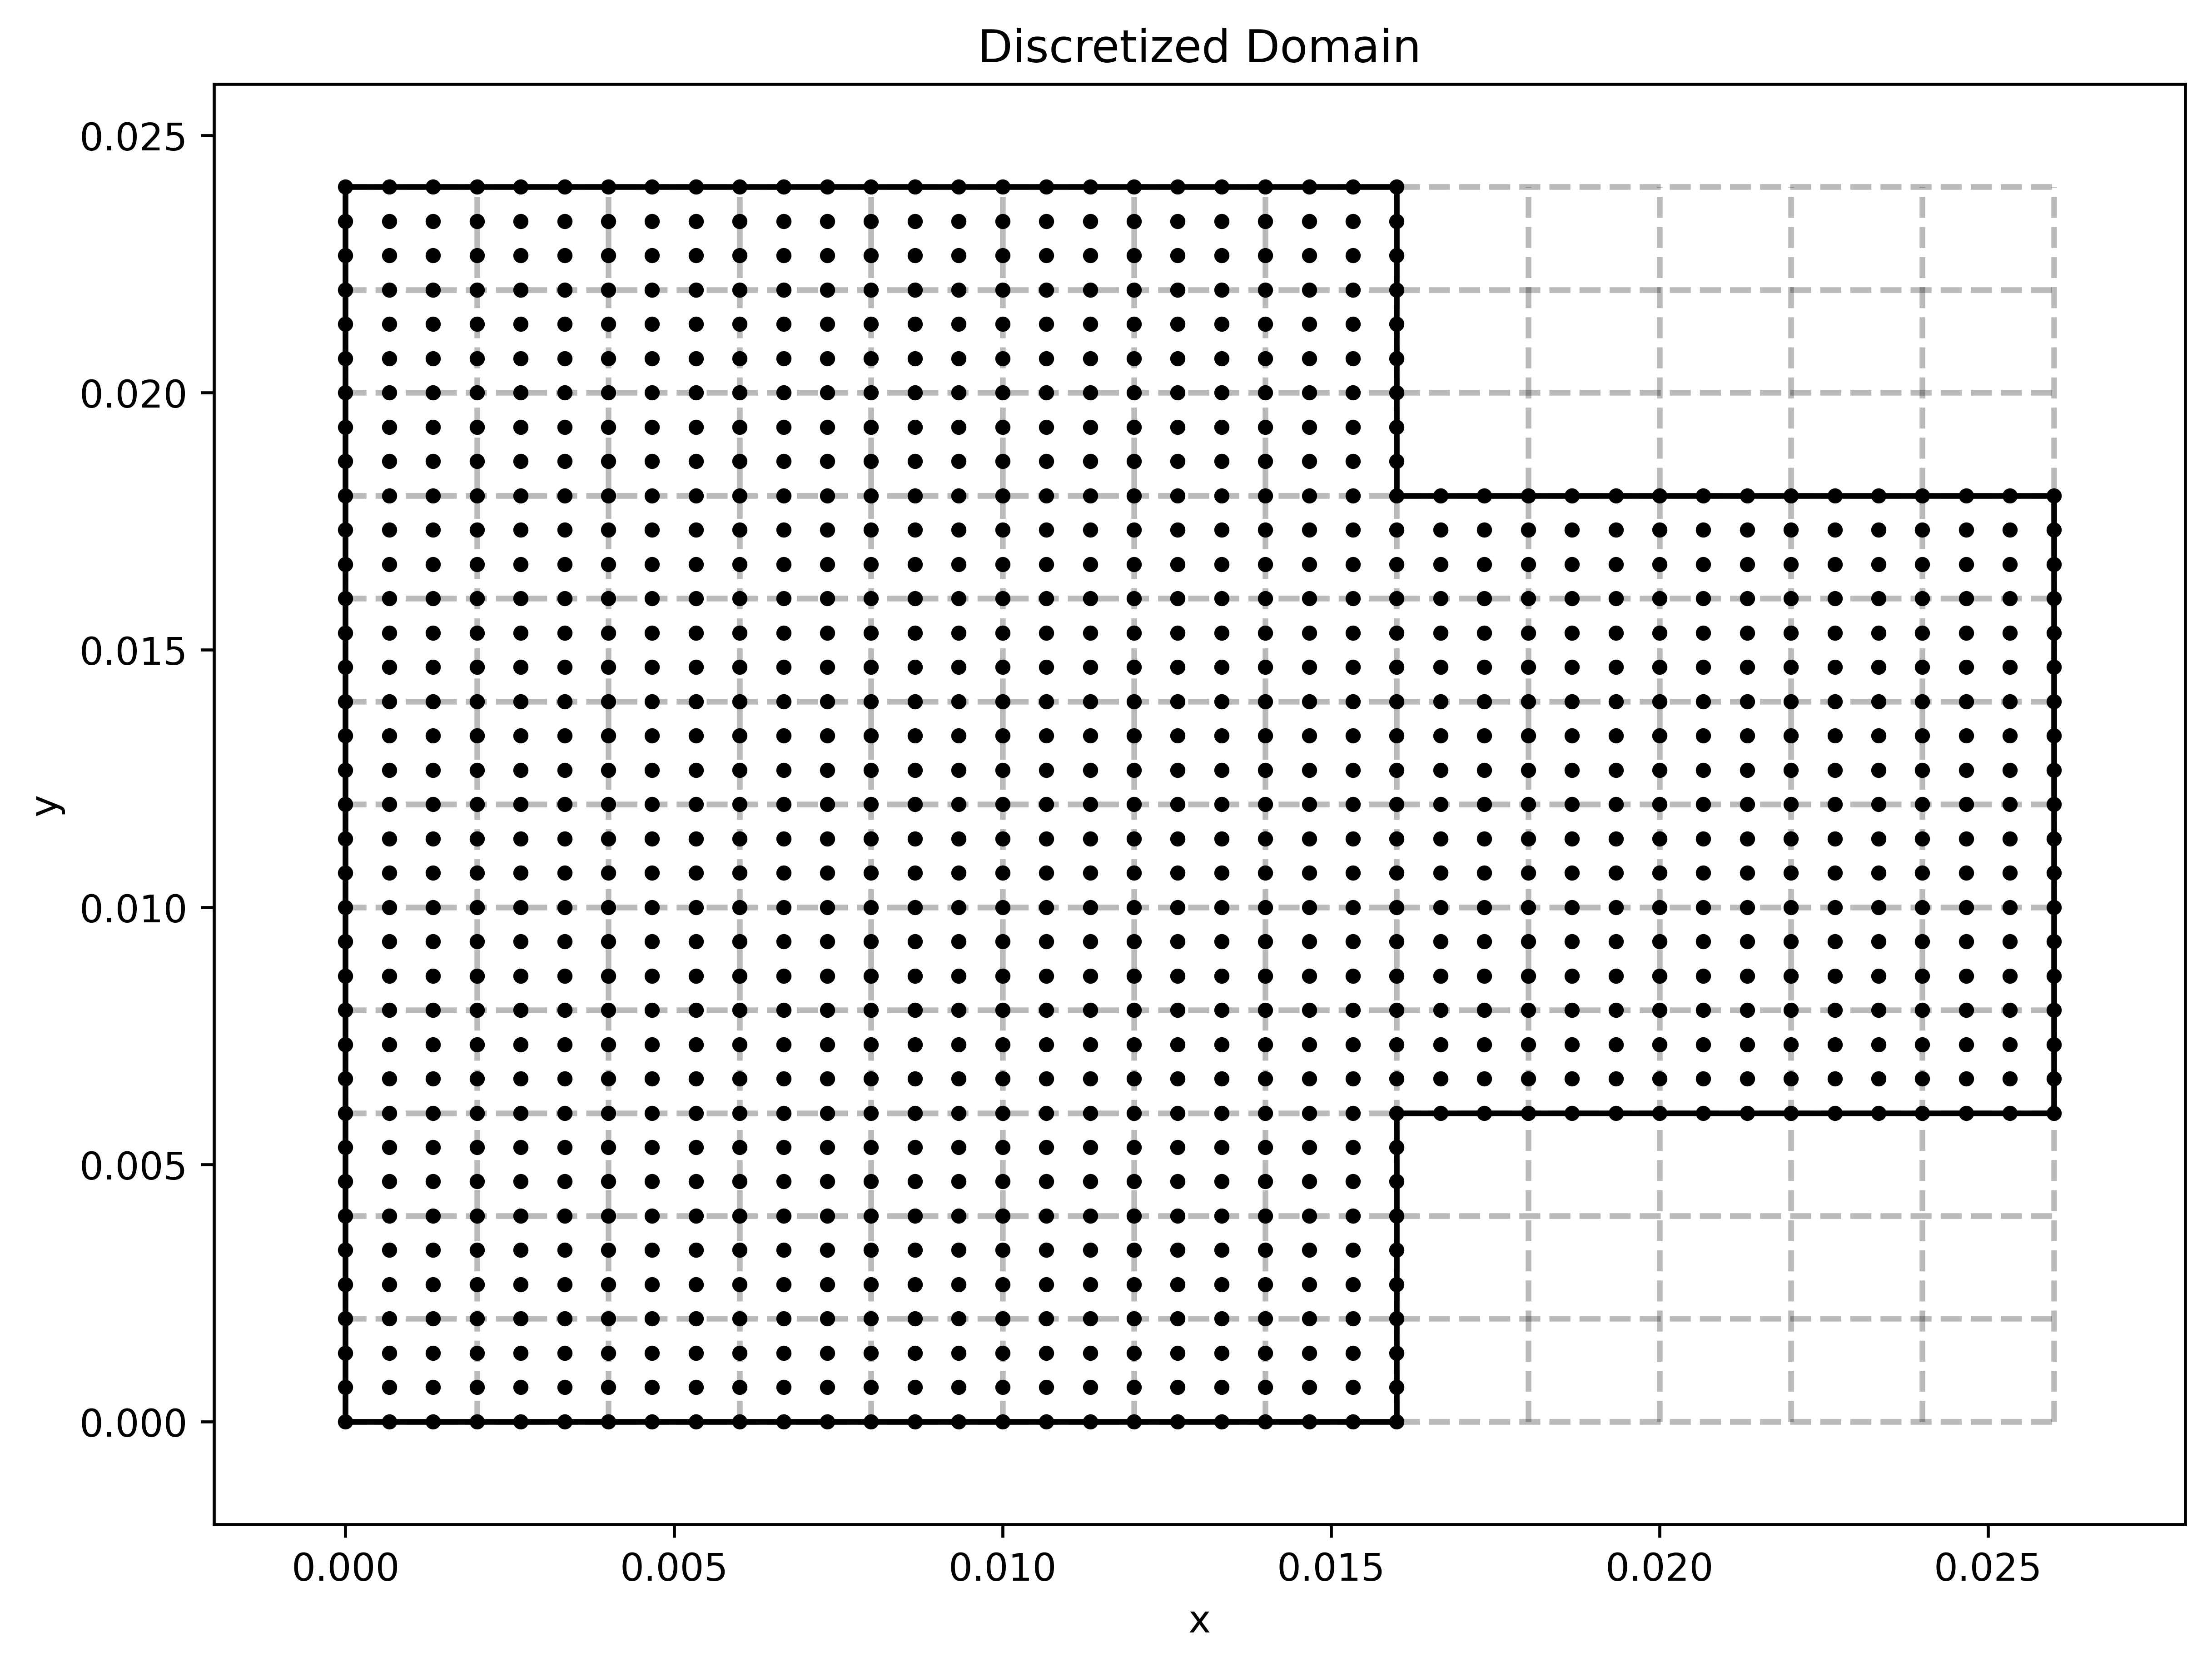

In [207]:
# Draw discretized domain

import matplotlib.pyplot as plt

# Domain Parameters
x_start, x_end, x_n = 0.0e-3, 26.0e-3, 13*1+1
y_start, y_end, y_n = 0.0e-3, 24.0e-3, 12*1+1

# Computes cell length & indices
dx = (x_end - x_start)/(x_n-1)
dy = (y_end - y_start)/(y_n-1)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 6),dpi=600)

ax.plot(XX[MASK],  YY[MASK],  marker='.', color='k', linestyle='none')
ax.plot(XX[~MASK], YY[~MASK], marker='.', color='w', linestyle='none')

# setting x and y axis range
ax.set_xlim(-2e-3, 28e-3)
ax.set_ylim(-2e-3, 26e-3)

# Boundary Conditions Lines
ax.plot([ 0e-3,  0e-3], [24e-3,  0e-3], color='k', linestyle='solid')  # B1 Hot Flux
ax.plot([ 0e-3, 16e-3], [ 0e-3,  0e-3], color='k', linestyle='solid')  # B2 Cold flux
ax.plot([16e-3, 16e-3], [ 0e-3,  6e-3], color='k', linestyle='solid')  # B3 Convection
ax.plot([16e-3, 26e-3], [ 6e-3,  6e-3], color='k', linestyle='solid')  # B4 Adiabatic
ax.plot([26e-3, 26e-3], [ 6e-3, 18e-3], color='k', linestyle='solid')  # B5 Constant Temperature
ax.plot([26e-3, 16e-3], [18e-3, 18e-3], color='k', linestyle='solid')  # B6 Constant Temperature
ax.plot([16e-3, 16e-3], [18e-3, 24e-3], color='k', linestyle='solid')  # B7 Adiabatic
ax.plot([16e-3,  0e-3], [24e-3, 24e-3], color='k', linestyle='solid')  # B8 Symmetric

# Specify a rectangular grid
ax.vlines(np.linspace(x_start, x_end, num=x_n), y_start, y_end, color='k', linestyle='dashed', alpha=0.27)
ax.hlines(np.linspace(y_start, y_end, num=y_n), x_start, x_end, color='k', linestyle='dashed', alpha=0.27)

# Plot labels
ax.set_title("Discretized Domain")
ax.set_xlabel('x') 
ax.set_ylabel('y') 

#plt.plot((16,16),(0,6), color='k', linestyle='solid')
plt.show()
fig.savefig('numerical_grid_05mm.png')

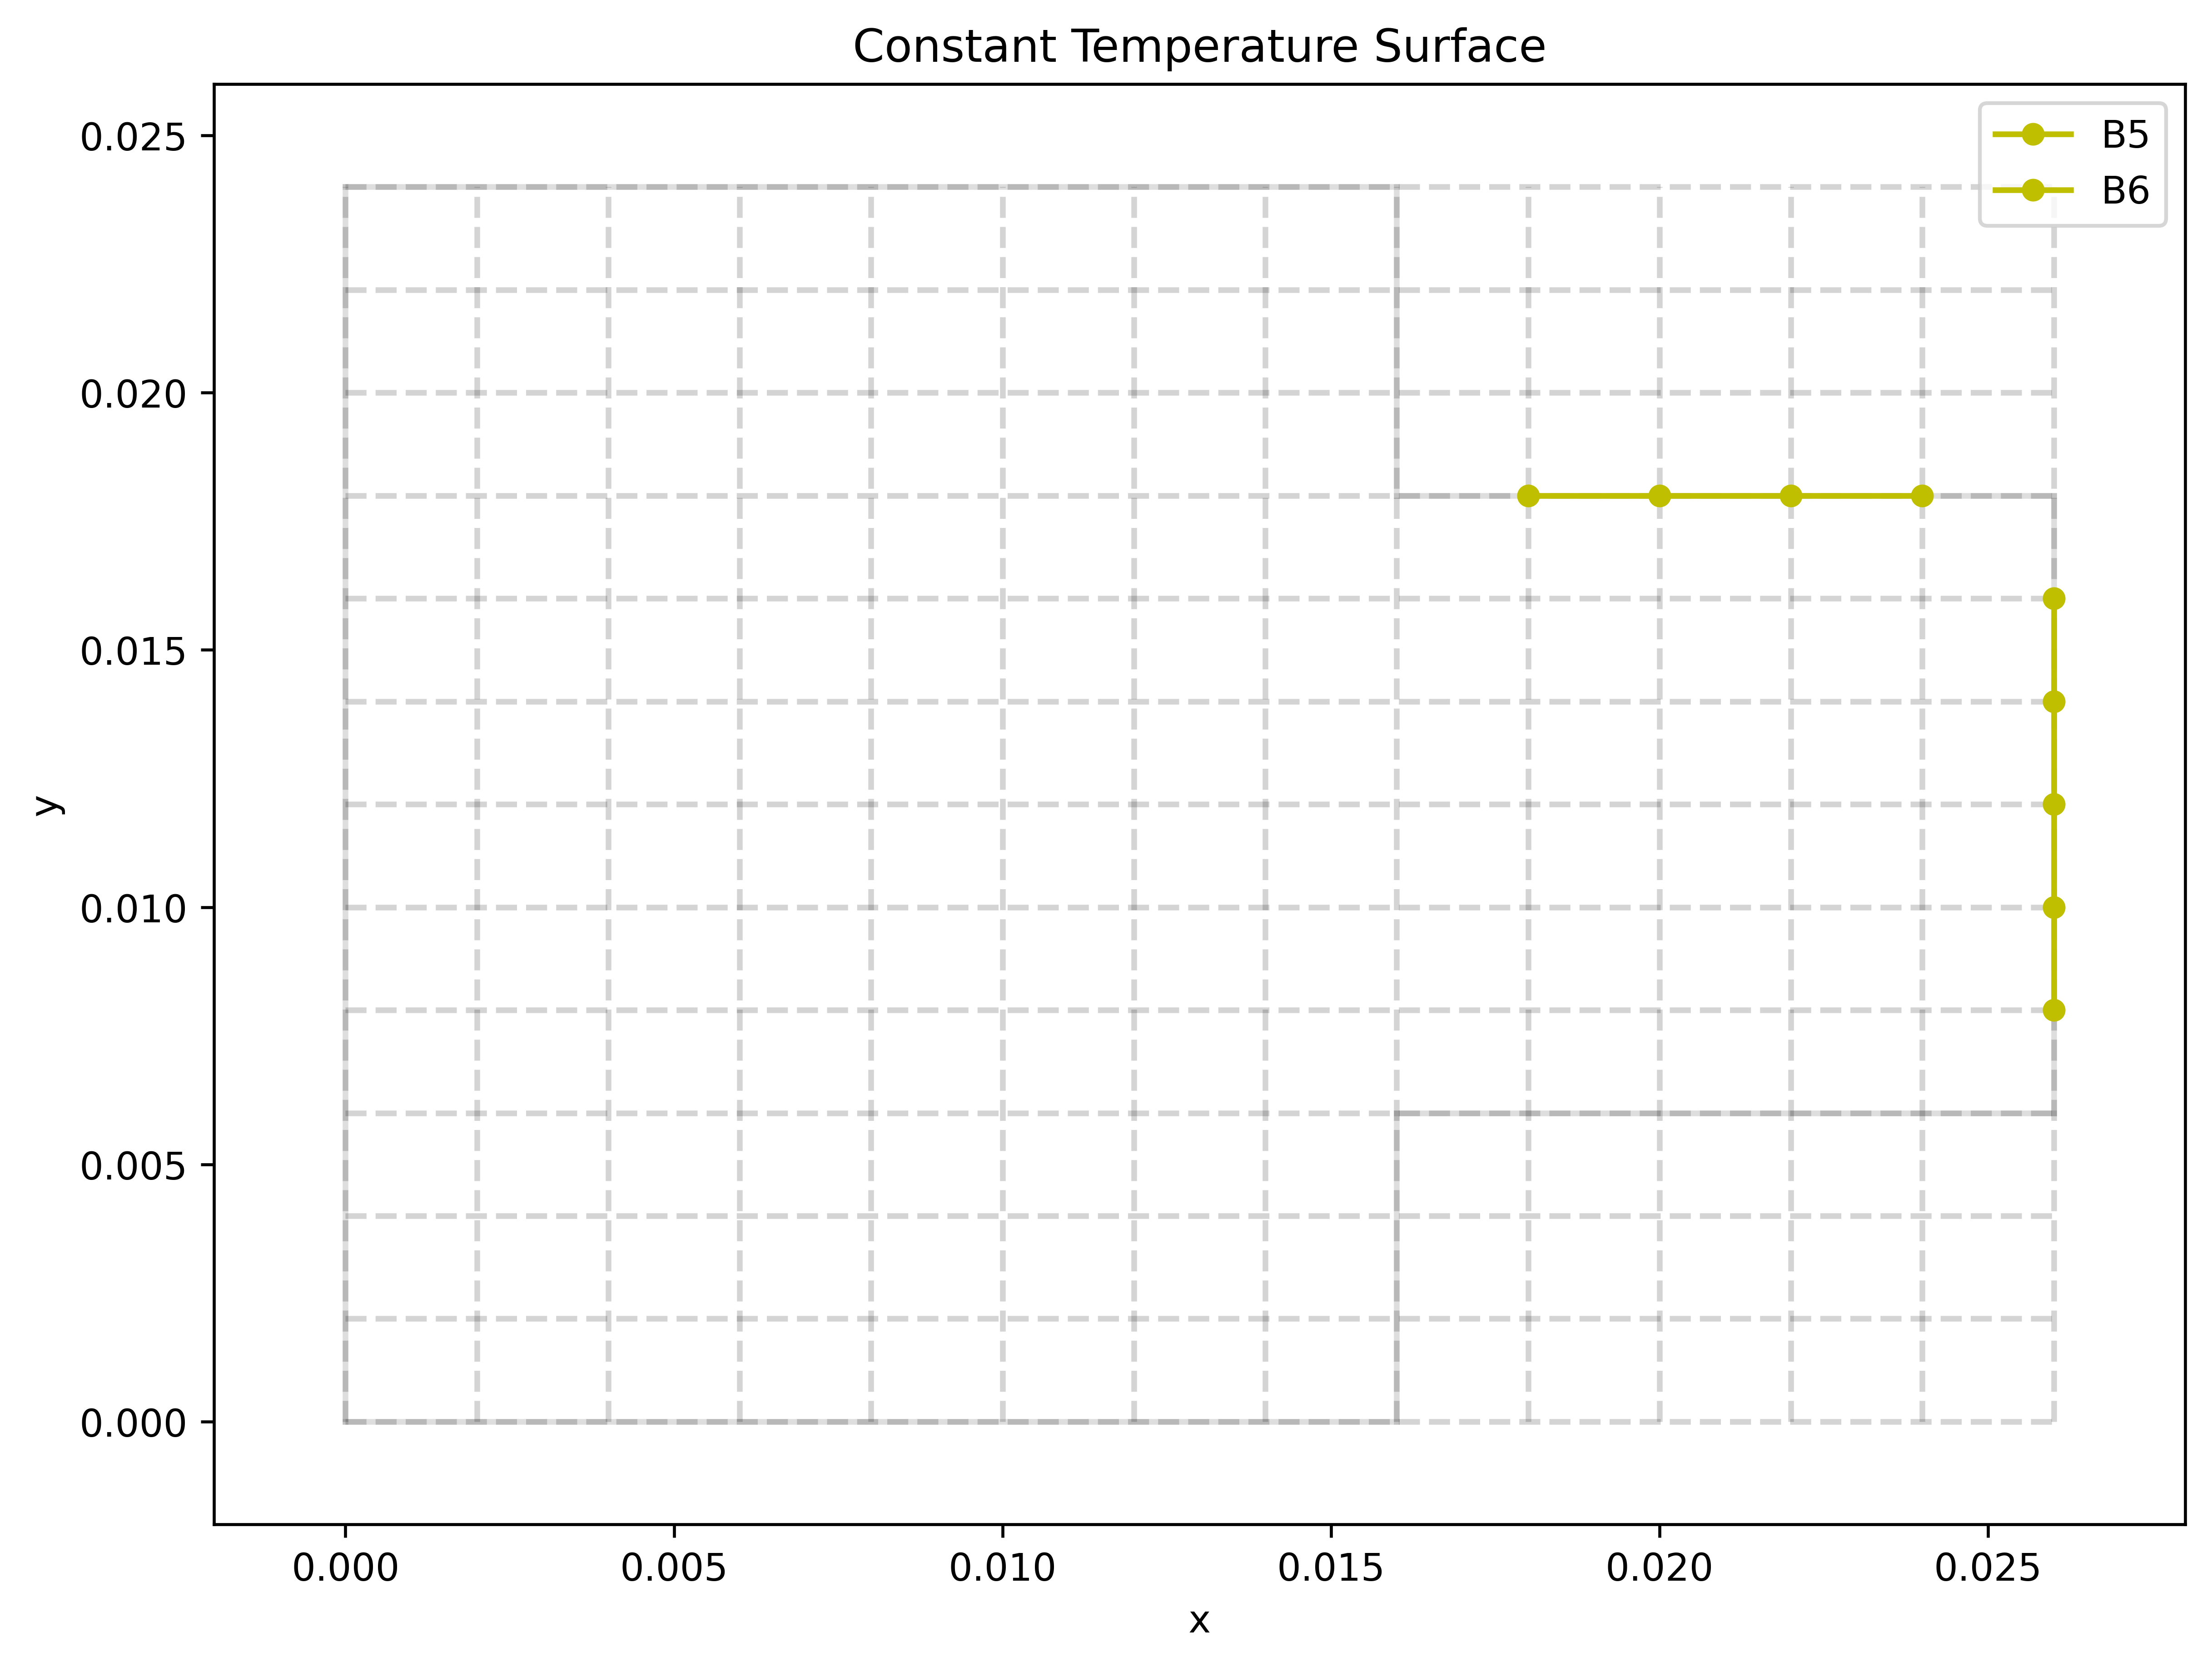

In [222]:
# Draw discretized domain
import matplotlib.pyplot as plt
import numpy as np

# Domain Parameters
x_start, x_end, x_n = 0.0e-3, 26.0e-3, 13*1+1
y_start, y_end, y_n = 0.0e-3, 24.0e-3, 12*1+1

# Computes cell length & indices
dx = (x_end - x_start)/(x_n-1)
dy = (y_end - y_start)/(y_n-1)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 6),dpi=600)

#ax.plot(XX[MASK],  YY[MASK],  marker='.', color='k', linestyle='none')
#ax.plot(XX[~MASK], YY[~MASK], marker='.', color='w', linestyle='none')

# setting x and y axis range
ax.set_xlim(-2e-3, 28e-3)
ax.set_ylim(-2e-3, 26e-3)

# Specify a rectangular grid
ax.vlines(np.linspace(x_start, x_end, num=x_n), y_start, y_end, color='k', linestyle='dashed', alpha=0.17)
ax.hlines(np.linspace(y_start, y_end, num=y_n), x_start, x_end, color='k', linestyle='dashed', alpha=0.17)

# Boundary Conditions Lines
ax.plot([ 0e-3,  0e-3], [24e-3,  0e-3], color='k', linestyle='solid', alpha=0.13)  # B1 Hot Flux
ax.plot([ 0e-3, 16e-3], [ 0e-3,  0e-3], color='k', linestyle='solid', alpha=0.13)  # B2 Cold flux
ax.plot([16e-3, 16e-3], [ 0e-3,  6e-3], color='k', linestyle='solid', alpha=0.13)  # B3 Convection
ax.plot([16e-3, 26e-3], [ 6e-3,  6e-3], color='k', linestyle='solid', alpha=0.13)  # B4 Adiabatic
ax.plot([26e-3, 26e-3], [ 6e-3, 18e-3], color='k', linestyle='solid', alpha=0.13)  # B5 Constant Temperature
ax.plot([26e-3, 16e-3], [18e-3, 18e-3], color='k', linestyle='solid', alpha=0.13)  # B6 Constant Temperature
ax.plot([16e-3, 16e-3], [18e-3, 24e-3], color='k', linestyle='solid', alpha=0.13)  # B7 Adiabatic
ax.plot([16e-3,  0e-3], [24e-3, 24e-3], color='k', linestyle='solid', alpha=0.13)  # B8 Symmetric

# B1 Hot Flux
B1 =  [(1,j)      for j in range(int(1+1), int(24e-3/dx)+1)]
B1x = [(i-1) * dx  for (i,j) in B1 ]
B1y = [(j-1) * dy for (i,j) in B1 ]
ax.plot(B1x, B1y,  marker='.', color='r',label='B1')

B12 =  [(1,1)]
B12x = [(i-1) * dx for (i,j) in B12 ]
B12y = [(j-1) * dy  for (i,j) in B12 ]
ax.plot(B12x, B12y,  marker='.', color='k',markersize=10)

# # B2 Cold flux
B2 =  [(i,1)      for i in range(int(1+1), int(16e-3/dx)+1)]
B2x = [(i-1) * dx for (i,j) in B2 ]
B2y = [(j-1) * dy  for (i,j) in B2 ]
ax.plot(B2x, B2y,  marker='.', color='b',label='B2')

B23 =  [(int(16e-3/dx)+1,1)]
B23x = [(i-1) * dx  for (i,j) in B23 ]
B23y = [(j-1) * dy  for (i,j) in B23]
ax.plot(B23x, B23y,  marker='.', color='k',markersize=10)

# B3 Convection
B3 =  [(int(16e-3/dx)+1,j)      for j in range(int(1+1), int(6e-3/dx)+1)]
B3x = [(i-1) * dx for (i,j) in B3 ]
B3y = [(j-1) * dy  for (i,j) in B3 ]
ax.plot(B3x, B3y,  marker='.', color='g',label='B3')

B34 =  [(int(16e-3/dx)+1,int(6e-3/dx)+1)]
B34x = [(i-1) * dx  for (i,j) in B34]
B34y = [(j-1) * dy  for (i,j) in B34]
ax.plot(B34x, B34y,  marker='.', color='k',markersize=10)

# # B4 Adiabatic
B4 =  [(i,int(6e-3/dx)+1)      for i in range(int(16e-3/dx)+2, int(26e-3/dx)+1)]
B4x = [(i-1) * dx for (i,j) in B4 ]
B4y = [(j-1) * dy  for (i,j) in B4 ]
ax.plot(B4x, B4y,  marker='.', color='k',label='B4')

B45 =  [(int(26e-3/dx)+1,int(6e-3/dx)+1)]
B45x = [(i-1) * dx  for (i,j) in B45]
B45y = [(j-1) * dy  for (i,j) in B45]
ax.plot(B45x, B45y,  marker='.', color='k',markersize=10)

# B5 Constant Temperature
B5 =  [(int(26e-3/dx)+1,j)      for j in range(int(6e-3/dx)+2, int(18e-3/dx)+1)]
B5x = [(i-1) * dx for (i,j) in B5 ]
B5y = [(j-1) * dy  for (i,j) in B5 ]
ax.plot(B5x, B5y,  marker='.', color='y',label='B5',markersize=10)

B56 =  [(int(26e-3/dx)+1,int(18e-3/dx)+1)]
B56x = [(i-1) * dx  for (i,j) in B56]
B56y = [(j-1) * dy  for (i,j) in B56]
ax.plot(B56x, B56y,  marker='.', color='k',markersize=10)

# B6 Constant Temperature
B6 =  [(i,int(18e-3/dx)+1)      for i in range(int(16e-3/dx)+2, int(26e-3/dx)+1)]
B6x = [(i-1) * dx for (i,j) in B6 ]
B6y = [(j-1) * dy  for (i,j) in B6 ]
ax.plot(B6x, B6y,  marker='.', color='y',label='B6',markersize=10)

B67 =  [(int(16e-3/dx)+1,int(18e-3/dx)+1)]
B67x = [(i-1) * dx  for (i,j) in B67]
B67y = [(j-1) * dy  for (i,j) in B67]
ax.plot(B67x, B67y,  marker='.', color='k',markersize=10)

# # B7 Adiabatic
B7 =  [(int(16e-3/dx)+1,j)      for j in range(int(18e-3/dx)+2, int(24e-3/dx)+1)]
B7x = [(i-1) * dx for (i,j) in B7 ]
B7y = [(j-1) * dy  for (i,j) in B7 ]
ax.plot(B7x, B7y,  marker='.', color='k',label='B7')

# B78 =  [(int(16e-3/dx)+1,int(24e-3/dx)+1)]
B78x = [(i-1) * dx  for (i,j) in B78]
B78y = [(j-1) * dy  for (i,j) in B78]
ax.plot(B78x, B78y,  marker='.', color='k',markersize=10)

# # B8 Symmetric
B8 =  [(i,int(24e-3/dx)+1)      for i in range(int(1+1), int(16e-3/dx)+1)]
B8x = [(i-1) * dx for (i,j) in B8 ]
B8y = [(j-1) * dy  for (i,j) in B8 ]
ax.plot(B8x, B8y,  marker='.', color='k',label='B8')

B81 =  [(1,int(24e-3/dx)+1)]
B81x = [(i-1) * dx  for (i,j) in B81]
B81y = [(j-1) * dy  for (i,j) in B81]
ax.plot(B81x, B81y,  marker='.', color='k',markersize=10)



# Plot labels
ax.set_title("Constant Temperature Surface")
ax.set_xlabel('x') 
ax.set_ylabel('y') 
ax.legend()

#plt.plot((16,16),(0,6), color='k', linestyle='solid')
plt.show()
fig.savefig('boundary_value_constant_temperature.png')

## Conversion of grid indeices to one-dimensional storage locations as column vectors

Linear system of equations in matrix form can be expressed as 
$$A U = Q$$
where A is the square sparse coefficient matrix, \phi is the column vector contained the variable values at the grid nodes and Q is the vector containing the terms on the right hand side of the equations. 

While our domain is defined as a grid, we need to convert the mesh into a vector to create an array of linear equations. The solution of the linear system should be undisturbed by the index conversion, but the structure of the grid will be expressed differently.

Since we have a 2D domain, with our variables indexed using two indices, we must convert our 2D domain of variables into a 1D column vector of variables for use in matrix algorithms, using lexicographic ordering (variables are labeled starting at a corner and traversing line after line in a regular manner). 

We shall do this in the natural column-wise order, such that the entries in vector u start at the southwest or bottomleft corner of the domain, proceeding northwards or upwards along the grid line, with lines of nodes numbered eastwards or right across the domain. Note that our node indices start at 1, keeping in line with math notation, and not with 0, used in computer science.

The conversion between the node indices and its location in the vector U is given by:

| Grid location | Storage Location |
|---------------|------------------|
| (i,j) | l = (i-1)N_j + j
| (i-1,j) | l - N_j 
| (i+1,j) | l + N_j
|(i,j+1) | l + 1
| (i, j-1) | l - 1


The structure of the matrix A depends on the numering of va

The below python code shows how to perform the conversion from grid space to vector form and back.

In [209]:
xvec_colwise = np.reshape(XX, (x_n)*(y_n))
yvec_colwise = np.reshape(YY, (x_n)*(y_n))

#print('xvec_colwise = \n', xvec_colwise)
#print('yvec_colwise = \n', yvec_colwise)

XX_new = np.reshape(np.ravel(xvec_colwise), (x_n,y_n))
print(f"XX_new == XX is {(XX_new == XX).all()}")

YY_new = np.reshape(np.ravel(yvec_colwise), (x_n,y_n))
print(f"YY_new == YY is {(YY_new == YY).all()}")

ValueError: cannot reshape array of size 1480 into shape (182,)

## Making the grid

## Kronecker product matrices

If grid arrays are converted to vectors using the natural row-wise or column-wise order, then finite difference operators such as the discrete Laplacian can be expressed as matrices that are the Kronecker product of 1-dimensional discretization matrices.

First here's a small example of Kronecker product matrices:
scipy.sparse

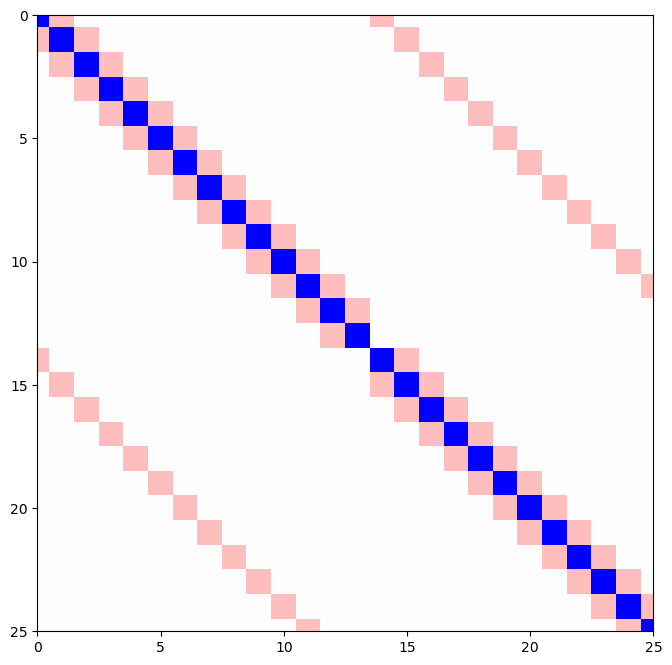

In [216]:
import scipy

# Domain Parameters
x_start, x_end, x_n = 0.0e-3, 26.0e-3, 13*1+1
y_start, y_end, y_n = 0.0e-3, 24.0e-3, 12*1+1

# Computes cell length & indices
dx = (x_end - x_start)/(x_n-1)
dy = (y_end - y_start)/(y_n-1)
def fd_2d_laplacian(x_n,y_n):
    # 1D discrete Laplacian in the x-direction
    Dxx = scipy.sparse.spdiags([np.ones(x_n), 
                                -2*np.ones(x_n), 
                                np.ones(x_n)], 
                               [-1, 0, 1], 
                               x_n, x_n) 

    #1D discrete Laplacian in the y-direction
    Dyy = scipy.sparse.spdiags([np.ones(y_n), 
                                -2*np.ones(y_n), 
                                np.ones(y_n)], 
                               [-1, 0, 1], 
                               y_n, y_n) 

    # Defining Laplacian matrix for grid (assume Dirichlet condition)
    L = scipy.sparse.kron(Dyy, np.eye(x_n)) + scipy.sparse.kron(np.eye(y_n), Dxx) 
    A = L.tolil() # Convert from CSR (meant for fast computation) to Lil (meant for building up incrementally)
    return A

A = fd_2d_laplacian(x_n,y_n)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(A.toarray(),interpolation='none',cmap='bwr',
           vmin = -4, vmax = 4)
# setting x and y axis range
ax.set_xlim(0, 25)
ax.set_ylim(25, 0)
plt.show()
fig.savefig('laplacian_matrix_closeup.png')


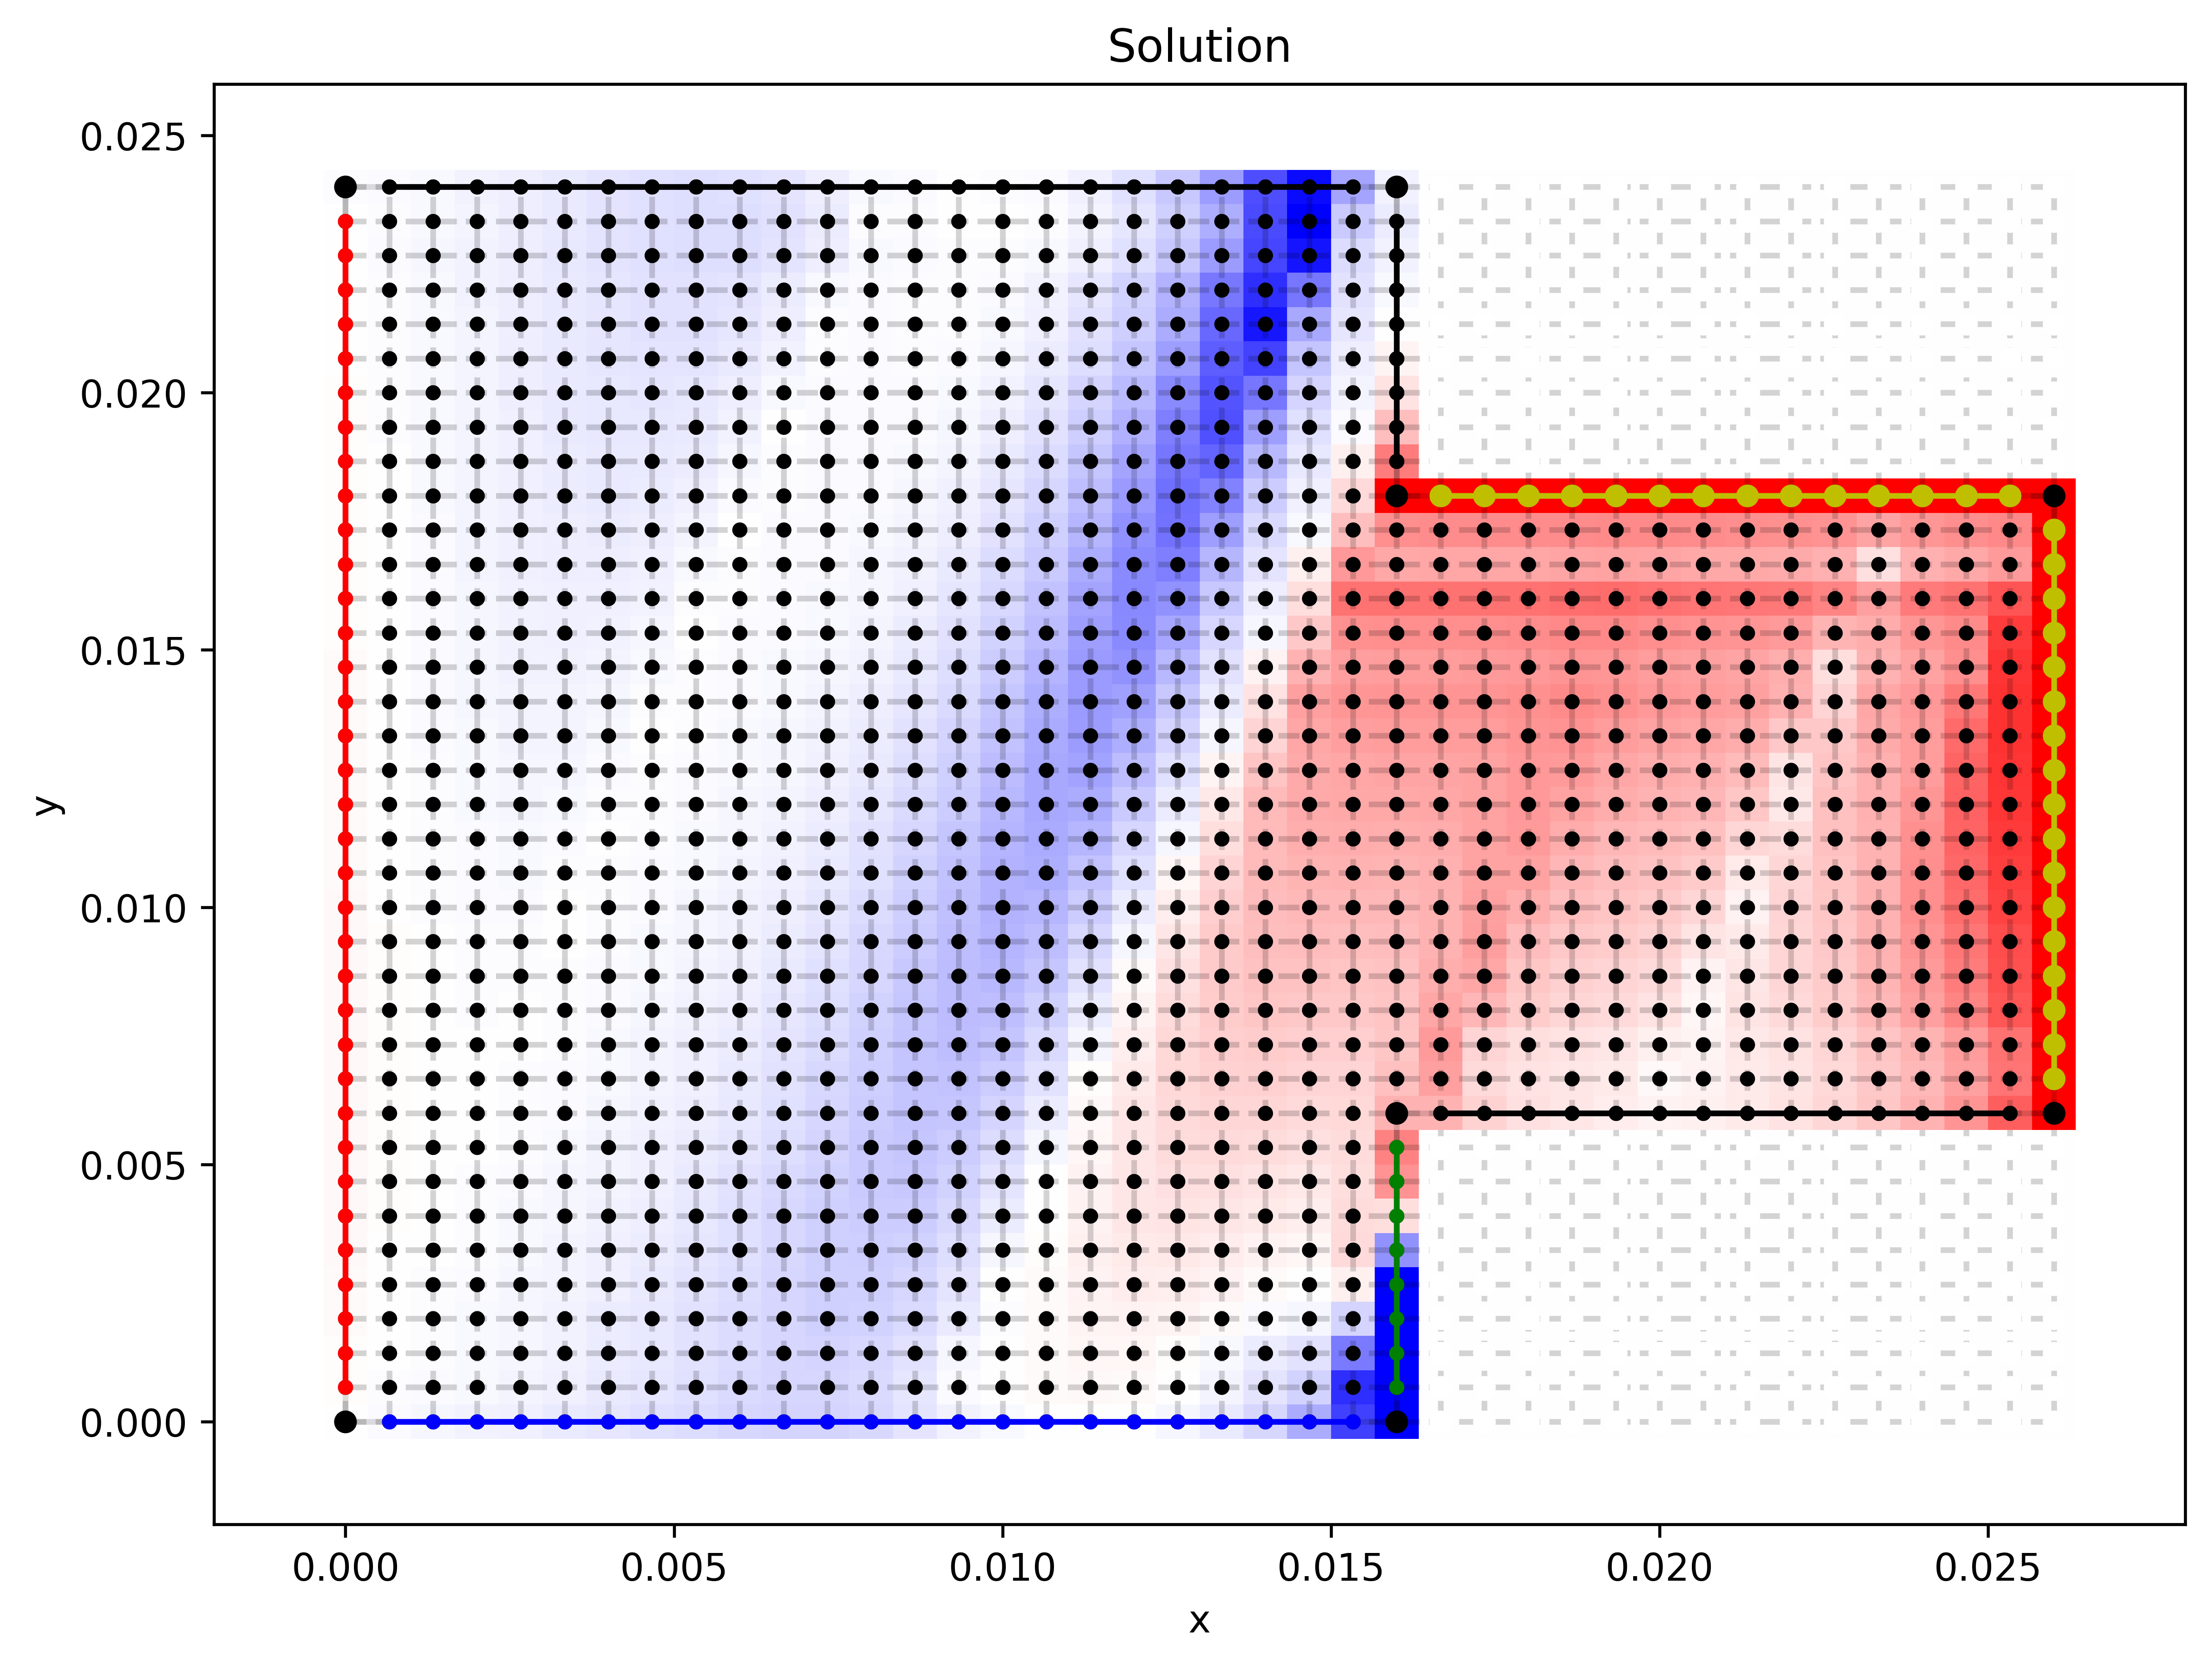

In [318]:
# Draw discretized domain
import matplotlib.pyplot as plt
import numpy as np
import scipy
import itertools


# Domain Parameters
x_start, x_end, x_n = 0.0e-3, 26.0e-3, 13*3+1
y_start, y_end, y_n = 0.0e-3, 24.0e-3, 12*3+1
dx = (x_end - x_start)/(x_n-1)
dy = (y_end - y_start)/(y_n-1)

# Constants
Tw = 120
T_inf = 25
C_hot = 50e3
C_cold = -50e3
k = 16
h = 400






# ################################
# # Initialize plotting commands #
# ################################

# Draw plot
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 6),dpi=600)

# Specify a rectangular grid
X = np.linspace(x_start, x_end, num=x_n) # mesh points in x dir
Y = np.linspace(y_start, y_end, num=y_n) # mesh points in y dir
XX, YY = np.meshgrid(X, Y, indexing="ij")
UU = np.zeros_like(XX)
MASK = (XX > 16e-3) & ( (YY < 6e-3 - 1e-6)|(YY > 18e-3 + 1e-6))
MASK = ~MASK

# Plot the rectangular grid
ax.plot(XX[MASK],  YY[MASK],  marker='.', color='k', linestyle='none')
ax.plot(XX[~MASK], YY[~MASK], marker='.', color='w', linestyle='none')

# Specify a rectangular grid
ax.vlines(np.linspace(x_start, x_end, num=x_n), y_start, y_end, color='k', linestyle='dashed', alpha=0.17)
ax.hlines(np.linspace(y_start, y_end, num=y_n), x_start, x_end, color='k', linestyle='dashed', alpha=0.17)

# Boundary Conditions Lines
ax.plot([ 0e-3,  0e-3], [24e-3,  0e-3], color='k', linestyle='solid', alpha=0.13)  # B1 Hot Flux
ax.plot([ 0e-3, 16e-3], [ 0e-3,  0e-3], color='k', linestyle='solid', alpha=0.13)  # B2 Cold flux
ax.plot([16e-3, 16e-3], [ 0e-3,  6e-3], color='k', linestyle='solid', alpha=0.13)  # B3 Convection
ax.plot([16e-3, 26e-3], [ 6e-3,  6e-3], color='k', linestyle='solid', alpha=0.13)  # B4 Adiabatic
ax.plot([26e-3, 26e-3], [ 6e-3, 18e-3], color='k', linestyle='solid', alpha=0.13)  # B5 Constant Temperature
ax.plot([26e-3, 16e-3], [18e-3, 18e-3], color='k', linestyle='solid', alpha=0.13)  # B6 Constant Temperature
ax.plot([16e-3, 16e-3], [18e-3, 24e-3], color='k', linestyle='solid', alpha=0.13)  # B7 Adiabatic
ax.plot([16e-3,  0e-3], [24e-3, 24e-3], color='k', linestyle='solid', alpha=0.13)  # B8 Symmetric









# ####################################
# # Initialize A matrix and Q vector # 
# ####################################

# Define coefficient matrix A (mostly laplacian) for LHS
Dxx = scipy.sparse.spdiags([np.ones(x_n), -2*np.ones(x_n), np.ones(x_n)], [-1, 0, 1], x_n, x_n) 
Dyy = scipy.sparse.spdiags([np.ones(y_n), -2*np.ones(y_n), np.ones(y_n)], [-1, 0, 1], y_n, y_n) 
L = scipy.sparse.kron(Dyy, np.eye(x_n)) + scipy.sparse.kron(np.eye(y_n), Dxx) 
A = L.tolil() # Convert from CSR (meant for fast computation) to Lil (meant for building up incrementally)

# Defining vector for RHS side of equations
Q = scipy.sparse.csr_matrix((x_n*y_n, 1)).tolil()








# #####################################
# # Set Boundary Conditions to domain #
# #####################################

# Add FD stencils to B1 - Hot Heat Flux
# #####################################
B1 =  [(1,j)      for j in range(int(2), int(24e-3/dx)+1)]
B1x = [(i-1) * dx for (i,j) in B1 ]
B1y = [(j-1) * dy for (i,j) in B1 ]
ax.plot(B1x, B1y,  marker='.', color='r',label='B1')

for (i,j) in B1:
    l = (i-1)*y_n + j - 1
    A[l,:] = 0       # Clear the row
    #A[l, l-y_n] = 0 #U[i-1, j  ]
    A[l, l-1] = 1    #U[i,   j-1]
    A[l, l] = -4     #U[i,   j  ]
    A[l, l+1] = 1    #U[i,   j+1]
    A[l, l+y_n] = 2  #U[i+1, j  ]
    Q[l] = -(2*C_hot*dx)/k        
    
# Add FD stencils to B12
# ######################
B12 =  [(1,1)]
B12x = [(i-1) * dx for (i,j) in B12 ]
B12y = [(j-1) * dy for (i,j) in B12 ]
ax.plot(B12x, B12y,  marker='.', color='k',markersize=10)

# Add FD stencils to B2 - Cold Heat Flux
# ######################################
B2 =  [(i,1)      for i in range(int(2), int(16e-3/dx)+1)]
B2x = [(i-1) * dx for (i,j) in B2 ]
B2y = [(j-1) * dy  for (i,j) in B2 ]
ax.plot(B2x, B2y,  marker='.', color='b',label='B2')

for (i,j) in B2:
    l = (i-1)*y_n + j - 1
    A[l,:] = 0       # Clear the row
    A[l, l-y_n] = 1  #U[i-1, j  ]
    #A[l, l-1] = 0    #U[i,   j-1]
    A[l, l] = -4     #U[i,   j  ]
    A[l, l+1] = 2    #U[i,   j+1]
    A[l, l+y_n] = 1  #U[i+1, j  ]
    Q[l] = -2*(C_cold*dx)/k        

# Add FD stencils to B23
# ######################    
B23 =  [(int(16e-3/dx)+1,1)]
B23x = [(i-1) * dx  for (i,j) in B23 ]
B23y = [(j-1) * dy  for (i,j) in B23]
ax.plot(B23x, B23y,  marker='.', color='k',markersize=10)

# Add FD stencils to B3 - Convection
# ##################################
B3 =  [(int(16e-3/dx)+1,j)      for j in range(int(2), int(6e-3/dx)+1)]
B3x = [(i-1) * dx for (i,j) in B3 ]
B3y = [(j-1) * dy  for (i,j) in B3 ]
ax.plot(B3x, B3y,  marker='.', color='g',label='B3')

for (i,j) in B3:
    l = (i-1)*y_n + j - 1
    A[l,:] = 0       # Clear the row
    A[l, l-y_n] = 2  #U[i-1, j  ]
    A[l, l-1] = 1    #U[i,   j-1]
    A[l, l] = -(2 + 2*dx*h/k)     #U[i,   j  ]
    A[l, l+1] = 1    #U[i,   j+1]
    #A[l, l+y_n] = 0  #U[i+1, j  ]
    Q[l] = 2*h*dx*T_inf/k        

# Add FD stencils to B34
# ######################
B34 =  [(int(16e-3/dx)+1,int(6e-3/dx)+1)]
B34x = [(i-1) * dx  for (i,j) in B34]
B34y = [(j-1) * dy  for (i,j) in B34]
ax.plot(B34x, B34y,  marker='.', color='k',markersize=10)

# Add FD stencils to B4 - Adiabatic
# #################################
B4 =  [(i,int(6e-3/dx)+1)      for i in range(int(16e-3/dx)+2, int(26e-3/dx)+1)]
B4x = [(i-1) * dx for (i,j) in B4 ]
B4y = [(j-1) * dy  for (i,j) in B4 ]
ax.plot(B4x, B4y,  marker='.', color='k',label='B4')

for (i,j) in B4:
    l = (i-1)*y_n + j - 1
    A[l,:] = 0       # Clear the row
    A[l, l-y_n] = 1  #U[i-1, j  ]
    #A[l, l-1] = 0    #U[i,   j-1]
    A[l, l] = -4     #U[i,   j  ]
    A[l, l+1] = 2    #U[i,   j+1]
    A[l, l+y_n] = 1  #U[i+1, j  ]
    Q[l] = 0

# Add FD stencils to B45 - Constant Temperature
# #############################################    
B45 =  [(int(26e-3/dx)+1,int(6e-3/dx)+1)]
B45x = [(i-1) * dx  for (i,j) in B45]
B45y = [(j-1) * dy  for (i,j) in B45]
ax.plot(B45x, B45y,  marker='.', color='k',markersize=10)

for (i,j) in B45:    
    l = (i-1)*y_n + j - 1
    A[l,:] = 0      # Clear the row
    A[l, l] = 1     #U[i,   j  ]
    Q[l] = Tw  

# Add FD stencils to B5 - Constant Temperature
# ############################################
B5 =  [(int(26e-3/dx)+1,j)      for j in range(int(6e-3/dx)+2, int(18e-3/dx)+1)]
B5x = [(i-1) * dx for (i,j) in B5 ]
B5y = [(j-1) * dy  for (i,j) in B5 ]
ax.plot(B5x, B5y,  marker='.', color='y',label='B5',markersize=10)

for (i,j) in B5:    
    l = (i-1)*y_n + j - 1
    A[l,:] = 0      # Clear the row
    A[l, l] = 1     #U[i,   j  ]
    Q[l] = Tw           

# Add FD stencils to B56 - Constant Temperature
# #############################################
B56 =  [(int(26e-3/dx)+1,int(18e-3/dx)+1)]
B56x = [(i-1) * dx  for (i,j) in B56]
B56y = [(j-1) * dy  for (i,j) in B56]
ax.plot(B56x, B56y,  marker='.', color='k',markersize=10)

for (i,j) in B56:    
    l = (i-1)*y_n + j - 1
    A[l,:] = 0      # Clear the row
    A[l, l] = 1     #U[i,   j  ]
    Q[l] = Tw  

# Add FD stencils to B6 - Constant Temperature
# ############################################
B6 =  [(i,int(18e-3/dx)+1)      for i in range(int(16e-3/dx)+2, int(26e-3/dx)+1)]
B6x = [(i-1) * dx for (i,j) in B6 ]
B6y = [(j-1) * dy for (i,j) in B6 ]
ax.plot(B6x, B6y,  marker='.', color='y',label='B6',markersize=10)

for (i,j) in B6:    
    l = (i-1)*y_n + j - 1
    A[l,:] = 0      # Clear the row
    A[l, l] = 1     #U[i,   j  ]
    Q[l] = Tw           

# Add FD stencils to B67 - Constant Temperature
# ####################################3########
B67 =  [(int(16e-3/dx)+1,int(18e-3/dx)+1)]
B67x = [(i-1) * dx  for (i,j) in B67]
B67y = [(j-1) * dy  for (i,j) in B67]
ax.plot(B67x, B67y,  marker='.', color='k',markersize=10)

for (i,j) in B67:    
    l = (i-1)*y_n + j - 1
    A[l,:] = 0      # Clear the row
    A[l, l] = 1     #U[i,   j  ]
    Q[l] = Tw  

# Add FD stencils to B7 - Adiabatic
# #################################
B7 =  [(int(16e-3/dx)+1,j)      for j in range(int(18e-3/dx)+2, int(24e-3/dx)+1)]
B7x = [(i-1) * dx for (i,j) in B7 ]
B7y = [(j-1) * dy  for (i,j) in B7 ]
ax.plot(B7x, B7y,  marker='.', color='k',label='B7')

for (i,j) in B7:
    l = (i-1)*y_n + j - 1
    A[l,:] = 0       # Clear the row
    A[l, l-y_n] = 1  #U[i-1, j  ]
    A[l, l-1] = 2    #U[i,   j-1]
    A[l, l] = -4     #U[i,   j  ]
    #A[l, l+1] = 0    #U[i,   j+1]
    A[l, l+y_n] = 1  #U[i+1, j  ]
    Q[l] = 0
    
# B78
B78 =  [(int(16e-3/dx)+1,int(24e-3/dx)+1)]
B78x = [(i-1) * dx  for (i,j) in B78]
B78y = [(j-1) * dy  for (i,j) in B78]
ax.plot(B78x, B78y,  marker='.', color='k',markersize=10)

# Add FD stencils to B7 - Symmetric
# #################################
B8 =  [(i,int(24e-3/dx)+1)      for i in range(int(1+1), int(16e-3/dx)+1)]
B8x = [(i-1) * dx for (i,j) in B8 ]
B8y = [(j-1) * dy  for (i,j) in B8 ]
ax.plot(B8x, B8y,  marker='.', color='k',label='B8')

for (i,j) in B8:
    l = (i-1)*y_n + j - 1
    A[l,:] = 0       # Clear the row
    A[l, l-y_n] = 1  #U[i-1, j  ]
    A[l, l-1] = 2    #U[i,   j-1]
    A[l, l] = -4     #U[i,   j  ]
    #A[l, l+1] = 0   #U[i,   j+1]
    A[l, l+y_n] = 1  #U[i+1, j  ]
    Q[l] = 0    

# B81
B81 =  [(1,int(24e-3/dx)+1)]
B81x = [(i-1) * dx  for (i,j) in B81]
B81y = [(j-1) * dy  for (i,j) in B81]
ax.plot(B81x, B81y,  marker='.', color='k',markersize=10)

# Add FD stencils to null nodes
# #############################
B_null_upper = [(i,j) for (i,j) in itertools.product(
    list(range(int(16e-3/dx)+2, int(26e-3/dx+2))), 
    list(range(int(18e-3/dx)+1+1, int(24e-3/dx)+2)))] 

for (i,j) in B_null_upper:
    l = (i-1)*y_n + j - 1
    A[l,:] = 0       # Clear the row
    #A[l, l-y_n] = 0  #U[i-1, j  ]
    #A[l, l-1] = 0    #U[i,   j-1]
    A[l, l] = 1     #U[i,   j  ]
    #A[l, l+1] = 0    #U[i,   j+1]
    #A[l, l+y_n] = 0  #U[i+1, j  ]
    Q[l] = 0  

B_null_upperx = [(i-1) * dx  for (i,j) in B_null_upper]
B_null_uppery = [(j-1) * dy  for (i,j) in B_null_upper]    
ax.plot(B_null_upperx, B_null_uppery,  
        marker='.', 
        color='w',
        markersize=10,
        linestyle='none',
        label='B_{null}')


B_null_lower = [(i,j) for (i,j) in itertools.product(
    range(int(16e-3/dx)+2, int(26e-3/dx+2)), 
    range(1, int(6e-3/dx)+1))]

for (i,j) in B_null_lower:
    l = (i-1)*y_n + j - 1
    A[l,:] = 0       # Clear the row
    #A[l, l-y_n] = 0  #U[i-1, j  ]
    #A[l, l-1] = 0    #U[i,   j-1]
    A[l, l] = 1     #U[i,   j  ]
    #A[l, l+1] = 0    #U[i,   j+1]
    #A[l, l+y_n] = 0  #U[i+1, j  ]
    Q[l] = 0  

B_null_lowerx = [(i-1) * dx  for (i,j) in B_null_lower]
B_null_lowery = [(j-1) * dy  for (i,j) in B_null_lower]    
ax.plot(B_null_lowerx, B_null_lowery,  
        marker='.', 
        color='w',
        markersize=10,
        linestyle='none',
        label='B_{null}')

#print(B_used)        
#print(B_null)    

# Plot labels
ax.set_title("Solution")
ax.set_xlabel('x') 
ax.set_ylabel('y') 
ax.set_xlim(-2e-3, 28e-3)
ax.set_ylim(-2e-3, 26e-3)
#ax.legend()

Ainv = scipy.sparse.linalg.inv(A.tocsc())
ans = Ainv.dot(Q)
UU = np.reshape(np.ravel(ans.toarray()), (x_n,y_n))
ax.pcolormesh(XX, YY, UU,cmap='bwr',vmin=-120,vmax=120)
#ax.imshow(ans,interpolation='none',cmap='bwr',extent=())

plt.show()
fig.savefig('boundary_value_constant_temperature.png')







#plt.imshow(A.toarray(),interpolation='none',cmap='bwr',
#           vmin = -4, vmax = 4)


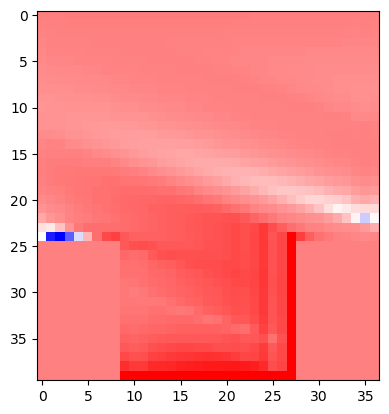

In [319]:
Ainv = scipy.sparse.linalg.inv(A.tocsc())
ans = Ainv.dot(Q)
#print(ans)
ans = np.reshape(np.ravel(ans.toarray()), (x_n,y_n))
plt.imshow(ans,interpolation='none',cmap='bwr')
#print(Linv)

In [40]:
Dxx = np.array([[0,  0, 0],
                [1, -2, 1],
                [0,  0, 0]])
Dyy = np.array([[0,  1, 0],
                [0, -2, 0],
                [0,  1, 0]])

I = np.diag((1,1))
print('T = \n',T)
print('I = \n',I)
#print('kron(A,B) = \n', np.kron(A,B))
#print('kron(B,A) = \n', np.kron(B,A))
print(np.kron(T,I)+np.kron(I,T))
plt.spy(np.kron(T,I)+np.kron(I,T))

NameError: name 'T' is not defined

## Boundary Conditions

### Constant Temperature
A constant temperature boundary condition dictates that the temperature at the designated boundary remains invariant over time. In other words, there is an heat source/sink at fixed temperature with infinitely large thermal conductivity that enforces the constant temperature at the boundary. Physically, constant temperature boundary conditions can be used to model the surface of materials undergoing phase-change (boiling, freezing, sublimation).

### Constant heat flux
A constant heat flux boundary condition dictates that the heat flux at the designated boundary remains invariant over time. In other words, the heat entering or leaving the system is fixed, regardless of the temperature. Physically, constant heat flux boundary conditions can be used to model electrical resistance heaters or radiative heating from a source that is at much higher temperature than the surface

### Adiabatic boundary
Adiabatic boundary condition dictates that no heat flows across the boundary. In other words, it is a perfect insulator that has a constant heat flux of zero. Physically, adiabatic boundaries can be used to model a well-insulated surface.

### Convection Boundary Conditions

A convection boundary condition occurs when the surface is exposed to convective heat transfer, with the temperature of the fluid often specified as a constant free stream temperature. Physically, convection boundaries can be used to model realistic heat sinks that use water or other fluids to wick away heat, as well as boilers that add heat through hot steam.

### Symmetric Boundary Condition
A symmetric boundary condition dictates that the same physical processes exist on both sides of the boundary. This condition is used when a physical model is symmetric such that all variables have the same value and gradients across a boundary and it would be computationally cheaper to only model one half of it.





Cite: https://www.wattco.com/2023/06/heat-conduction-boundary-conditions/

/tmp/ipykernel_1548131/1529854499.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


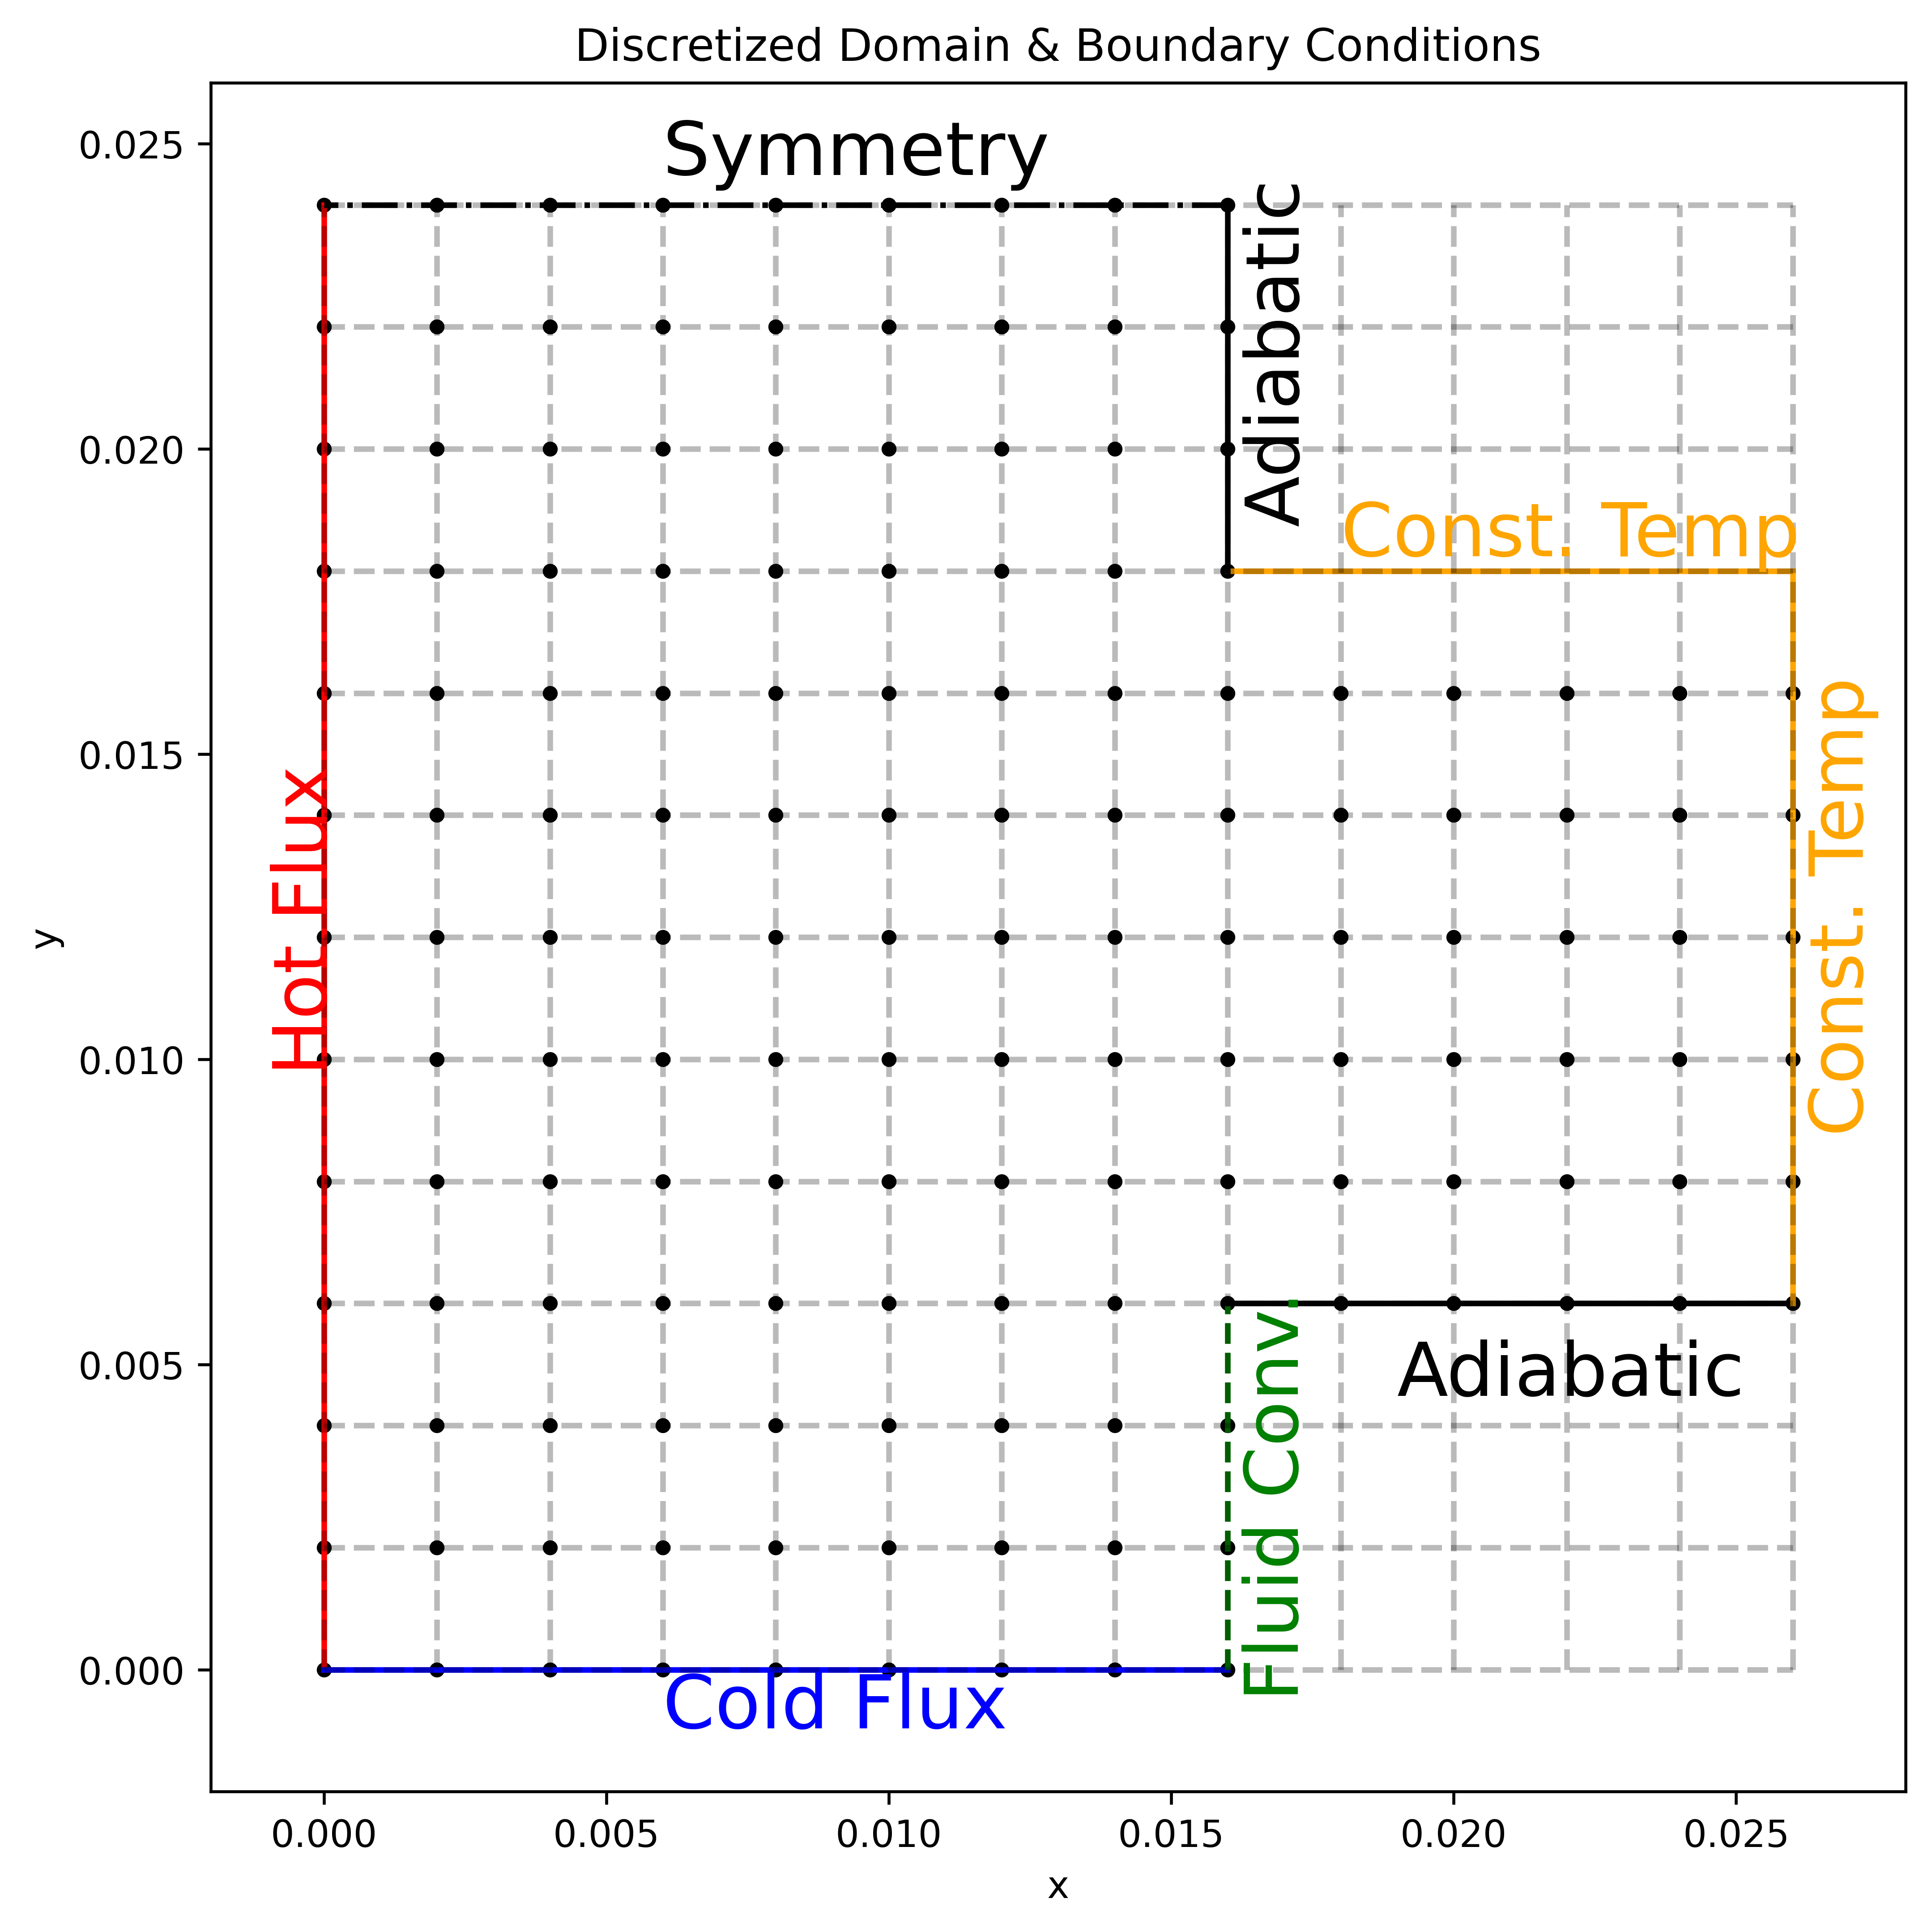

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(3.54*2, 3.54*2), dpi=600)
ax.plot(XX[MASK],  YY[MASK],  marker='.', color='k', linestyle='none',alpha=1.00)
ax.plot(XX[~MASK], YY[~MASK], marker='.', color='w', linestyle='none',alpha=0.27)

# setting x and y axis range
ax.set_xlim(-2e-3, 28e-3)
ax.set_ylim(-2e-3, 26e-3)

# Boundary Conditions Lines
ax.plot([ 0e-3,  0e-3], [24e-3,  0e-3], color='r', linestyle='solid')  # B1 Hot Flux
ax.plot([ 0e-3, 16e-3], [ 0e-3,  0e-3], color='b', linestyle='solid')  # B2 Cold flux
ax.plot([16e-3, 16e-3], [ 0e-3,  6e-3], color='g', linestyle='dashed') # B3 Convection
ax.plot([16e-3, 26e-3], [ 6e-3,  6e-3], color='k', linestyle='solid')  # B4 Adiabatic
ax.plot([26e-3, 26e-3], [ 6e-3, 18e-3], color='orange', linestyle='solid')  # B5 Constant Temperature
ax.plot([26e-3, 16e-3], [18e-3, 18e-3], color='orange', linestyle='solid')  # B6 Constant Temperature
ax.plot([16e-3, 16e-3], [18e-3, 24e-3], color='k', linestyle='solid')  # B7 Adiabatic
ax.plot([16e-3,  0e-3], [24e-3, 24e-3], color='k', linestyle='dashdot')  # B8 Symmetric

# Boundary Conditions Text
ax.text( -0.95e-3,    10e-3, "Hot Flux",    color = 'red',    rotation = 90, fontsize="20")
ax.text(     6e-3, -0.95e-3, "Cold Flux",   color = 'blue',   rotation = 0,  fontsize="20")
ax.text( 16.25e-3, -0.25e-3, "Fluid Conv.", color = 'green',  rotation = 90, fontsize="20")
ax.text(    19e-3,   4.5e-3, "Adiabatic",   color = 'black',  rotation = 0,  fontsize="20")
ax.text( 26.25e-3,     9e-3, "Const. Temp", color = 'orange', rotation = 90, fontsize="20")
ax.text(    18e-3, 18.25e-3, "Const. Temp", color = 'orange', rotation = 0,  fontsize="20")
ax.text( 16.25e-3,    19e-3, "Adiabatic",   color = 'black',  rotation = 90, fontsize="20")
ax.text(     6e-3,  24.5e-3, "Symmetry",    color = 'black',  rotation = 0,  fontsize="20")

# Specify a rectangular grid
ax.vlines(np.linspace(x_start, x_end, num=x_n), y_start, y_end, color='k', linestyle='dashed', alpha=0.27)
ax.hlines(np.linspace(y_start, y_end, num=y_n), x_start, x_end, color='k', linestyle='dashed', alpha=0.27)

# Plot labels
ax.set_title("Discretized Domain & Boundary Conditions")
ax.set_xlabel('x') 
ax.set_ylabel('y') 

#plt.plot((16,16),(0,6), color='k', linestyle='solid')
fig.show()
plt.savefig('boundary_conditions.png')